# test area

In [1]:
import os, sys
import seaborn as sb
import pandas as pd
from datetime import datetime

from pandas_plots import tbl, pls, ven , hlp, pii
from pandas_plots.hlp import OperatingSystem

hlp.show_package_version()
df = sb.load_dataset('taxis')
os.environ['THEME'] = 'dark'


 🐍 3.10.12 | 📦 pandas: 2.2.2 | 📦 numpy: 1.26.4 | 📦 duckdb: 1.0.0 | 📦 pandas-plots: 0.11.11 | 📦 connection_helper: 0.8.0


🔵 *** df: test ***
🟣 shape: (6_433, 14) columns: ['pickup', 'dropoff', 'passengers', 'distance', 'fare', 'tip', 'tolls', 'total', 'color', 'payment', 'pickup_zone', 'dropoff_zone', 'pickup_borough', 'dropoff_borough'] 
🟣 duplicates: 0
🟣 missings: {'pickup': 0, 'dropoff': 0, 'passengers': 0, 'distance': 0, 'fare': 0, 'tip': 0, 'tolls': 0, 'total': 0, 'color': 0, 'payment': 44, 'pickup_zone': 26, 'dropoff_zone': 45, 'pickup_borough': 26, 'dropoff_borough': 45}
--- column uniques (all)
🟠 index [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 
27, 28, 29,]
🟠 pickup(6_414|datetime64[ns]) [2019-02-28 23:29:03, 2019-03-01 00:03:29, 2019-03-01 00:08:32, 2019-03-01 00:15:53, 
2019-03-01 00:29:22, 2019-03-01 00:30:59, 2019-03-01 00:32:49, 2019-03-01 00:53:00, 
2019-03-01 00:56:50, 2019-03-01 01:25:30, 2019-03-01 02:41:51, 2019-03-01 02:51:42, 
2019-03-01 02:55:55, 2019-03-01 04:19:39, 2019-03-01 04:30:28, 2019-03-01 04:34:21, 
2019-03-01 05:18:21

,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,pickup_zone,dropoff_zone,pickup_borough,dropoff_borough
0,2019-03-23 20:21:09,2019-03-23 20:27:24,1,1.60,7.0,2.15,0.0,12.95,yellow,credit card,Lenox Hill West,UN/Turtle Bay South,Manhattan,Manhattan
1,2019-03-04 16:11:55,2019-03-04 16:19:00,1,0.79,5.0,0.00,0.0,9.30,yellow,cash,Upper West Side South,Upper West Side South,Manhattan,Manhattan
2,2019-03-27 17:53:01,2019-03-27 18:00:25,1,1.37,7.5,2.36,0.0,14.16,yellow,credit card,Alphabet City,West Village,Manhattan,Manhattan


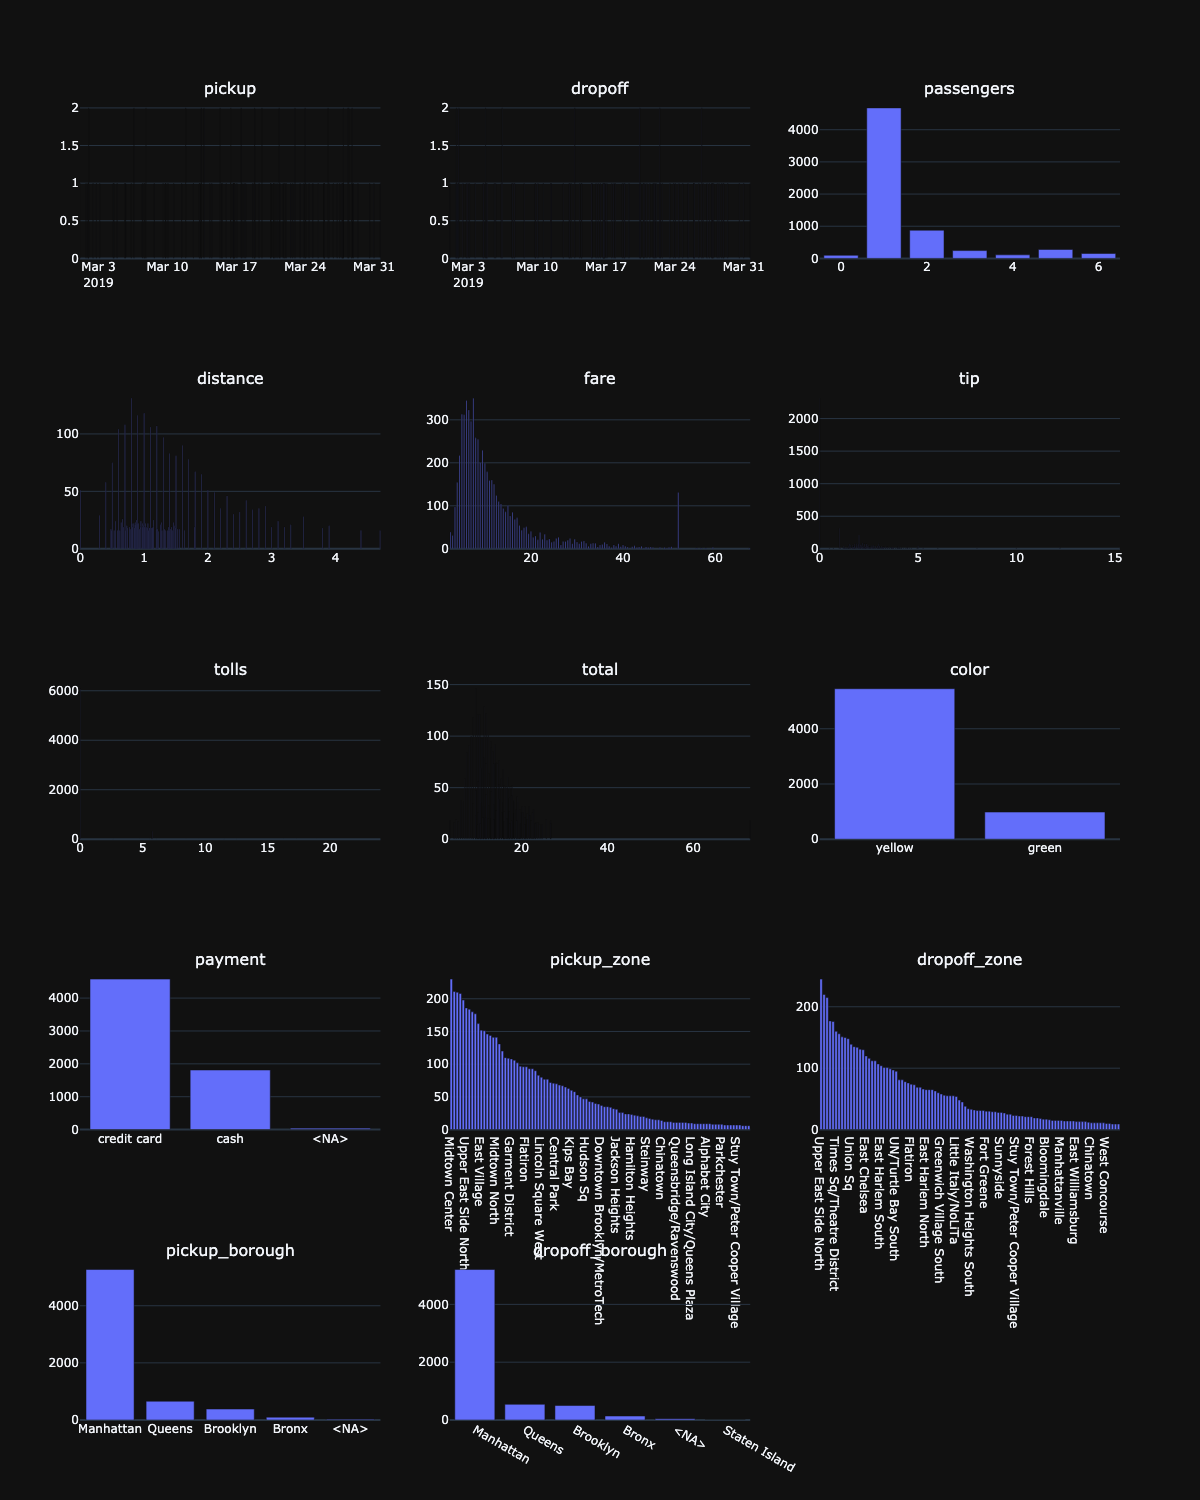

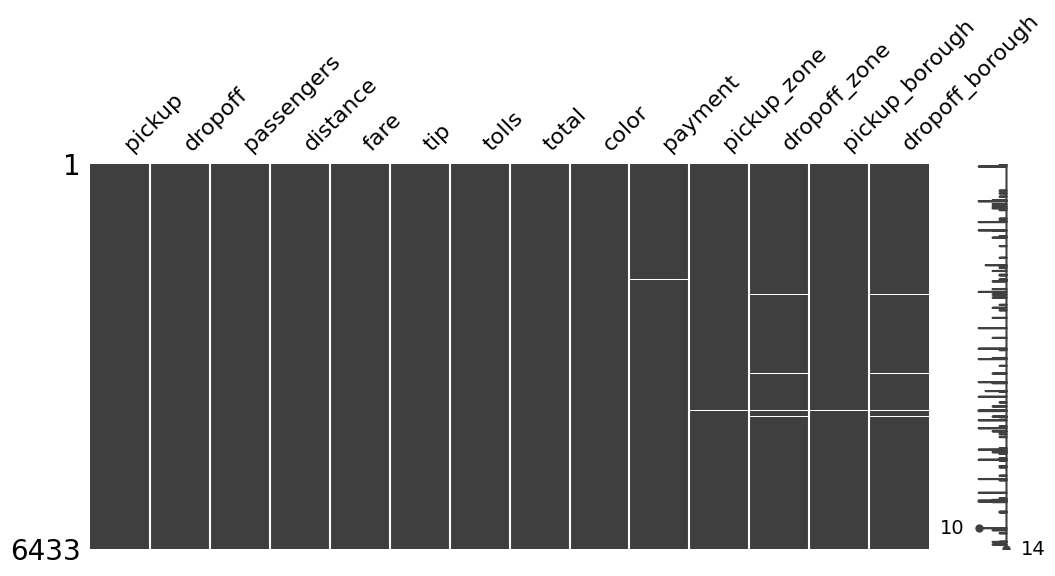

In [3]:
tbl.describe_df(
    df,
    "test",
    use_plot=True,
    use_columns=True,
    use_missing=True,
)

In [3]:
sys.exit()

SystemExit: 

In [2]:
# Example data: names and corresponding dates
data = ["Alice", "Bob", "Charlie", "Dr. David", "DrEve lol 23.05.2020", None, ""]
df = pd.DataFrame(data, columns=['Data'])
df['New_Column'] = [10, 20, 30, 40, 50, 60, 70]

# Print the Series
print(df)

_ = pii.remove_pii(df['Data'], logging=True, verbose=True,custom_regex=r"Bob")
df.drop(axis=0, index=_, inplace=False)

                   Data  New_Column
0                 Alice          10
1                   Bob          20
2               Charlie          30
3             Dr. David          40
4  DrEve lol 23.05.2020          50
5                  None          60
6                                70
found 3 pii items:
['Bob', 'Dr. David', 'DrEve lol 23.05.2020']


,Data,New_Column
0,Alice,10
2,Charlie,30
5,None,60
6,,70


In [ ]:
hlp.get_os(OperatingSystem.MAC)

💻 os: posix | 🎯 system: Darwin | 💽 release: 23.5.0


True

## describe

🔵 *** df: dataframe ***
🟣 shape: (6_433, 14) columns: ['pickup', 'dropoff', 'passengers', 'distance', 'fare', 'tip', 'tolls', 'total', 'color', 'payment', 'pickup_zone', 'dropoff_zone', 'pickup_borough', 'dropoff_borough'] 
🟣 duplicates: 0
🟣 missings: {'pickup': 0, 'dropoff': 0, 'passengers': 0, 'distance': 0, 'fare': 0, 'tip': 0, 'tolls': 0, 'total': 0, 'color': 0, 'payment': 44, 'pickup_zone': 26, 'dropoff_zone': 45, 'pickup_borough': 26, 'dropoff_borough': 45}
--- column uniques (all)
🟠 index [0, 1, 2, 3, 4,]
🟠 pickup(6_414|datetime64[ns]) [2019-02-28 23:29:03, 2019-03-01 00:03:29, 2019-03-01 00:08:32, 2019-03-01 00:15:53, 
2019-03-01 00:29:22,]
🟠 dropoff(6_425|datetime64[ns]) [2019-02-28 23:32:35, 2019-03-01 00:13:32, 2019-03-01 00:29:47, 2019-03-01 00:32:48, 
2019-03-01 00:37:39,]
🟠 passengers(7|int64) [0, 1, 2, 3, 4,]
🟠 distance(1_079|float64) [0.0, 0.01, 0.02, 0.03, 0.04,]
🟠 fare(220|float64) [1.0, 2.5, 3.0, 3.5, 4.0,]
🟠 tip(489|float64) [0.0, 0.01, 0.02, 0.06, 0.08,]
🟠 tolls(16

,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,pickup_zone,dropoff_zone,pickup_borough,dropoff_borough
0,2019-03-23 20:21:09,2019-03-23 20:27:24,1,1.60,7.0,2.15,0.0,12.95,yellow,credit card,Lenox Hill West,UN/Turtle Bay South,Manhattan,Manhattan
1,2019-03-04 16:11:55,2019-03-04 16:19:00,1,0.79,5.0,0.00,0.0,9.30,yellow,cash,Upper West Side South,Upper West Side South,Manhattan,Manhattan
2,2019-03-27 17:53:01,2019-03-27 18:00:25,1,1.37,7.5,2.36,0.0,14.16,yellow,credit card,Alphabet City,West Village,Manhattan,Manhattan


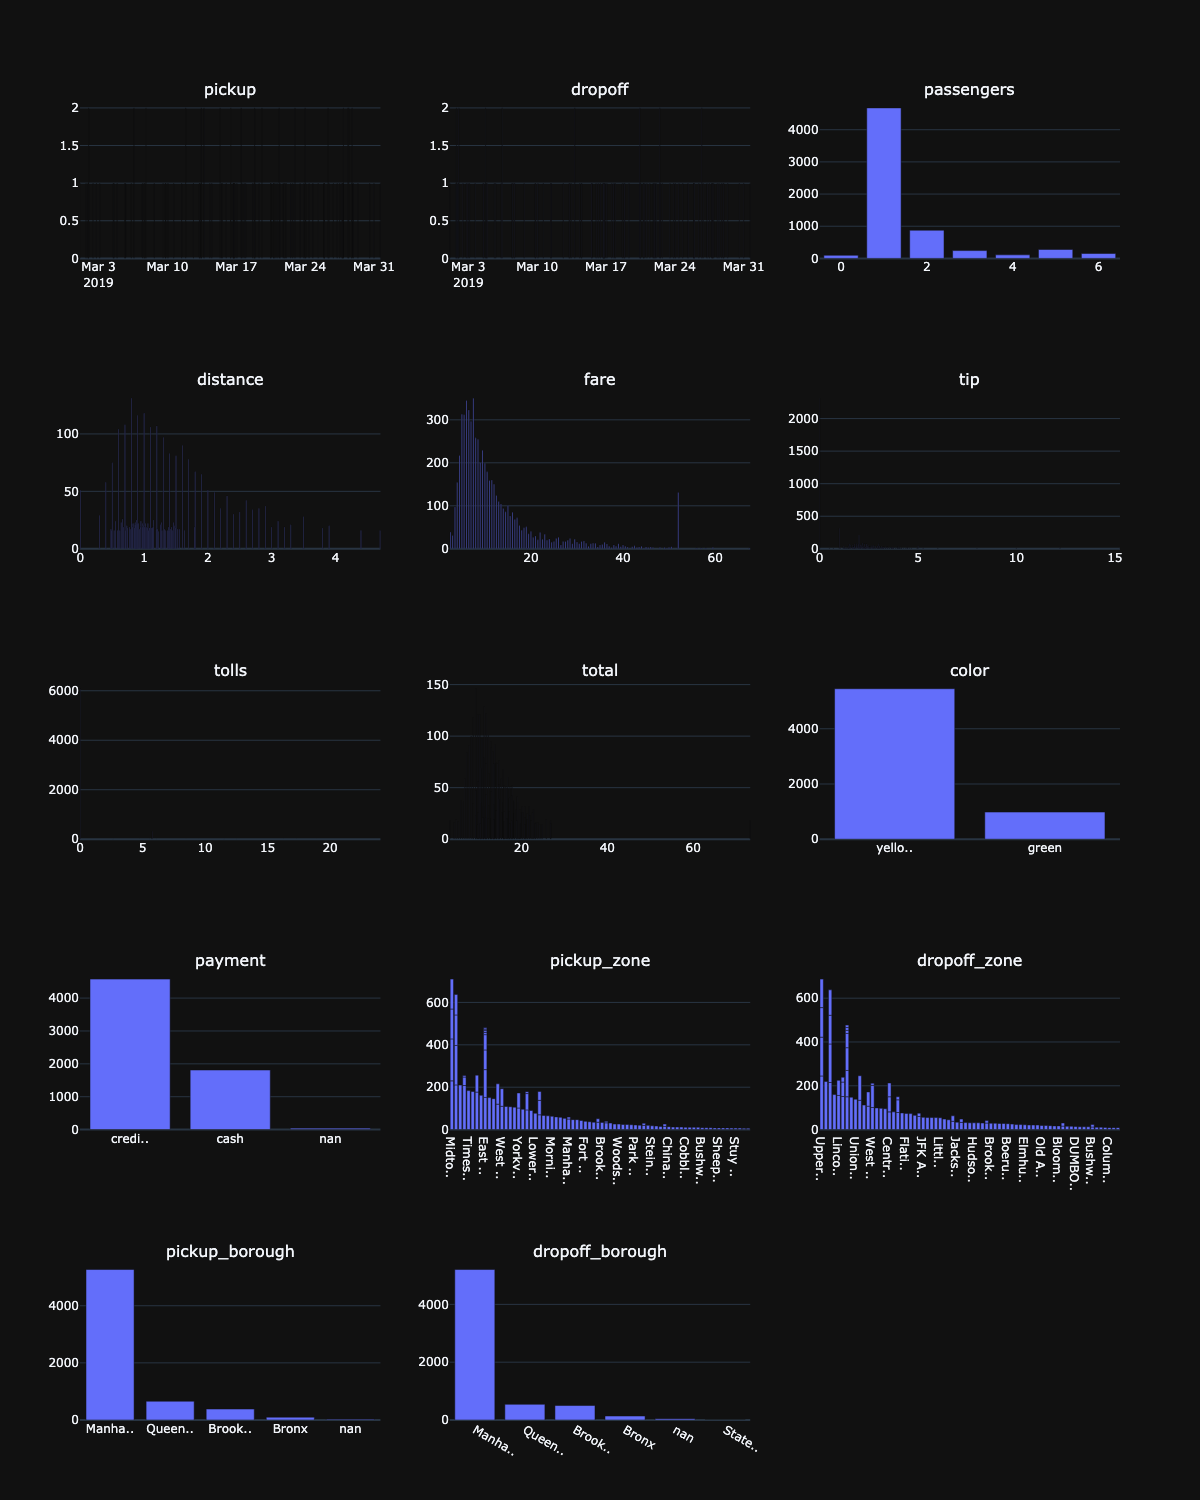

In [ ]:

tbl.describe_df(df, 'dataframe', top_n_uniques=5, top_n_chars_in_index=5)
# lol=txt.wrap(list(df['passengers'].sort_values().value_counts().index), max_items_in_line=40)
# lol=wrap('kldjfldjfljö', max_items_in_line=40)
# lol=list(df['passengers'].value_counts().sort_index().index)[:3]
# lol
# txt.wrap(lol)

## show num

In [ ]:
_df = df[["passengers", "distance", "fare"]][:5]
tbl.show_num_df(
    _df,
    total_axis="xy",
    total_mode="mean",
    data_bar_axis="xy",
    pct_axis="",
    precision=2,
    total_exclude=False,
    show_as_pct=True,
    # kpi_mode="",
    # kpi_mode="max_min_x",
    # kpi_rag_list=(1,7),
)

,passengers,distance,fare,Total
0,100.00%,160.00%,700.00%,320.00%
1,100.00%,79.00%,500.00%,226.33%
2,100.00%,137.00%,750.00%,329.00%
3,100.00%,770.00%,2700.00%,1190.00%
4,300.00%,216.00%,900.00%,472.00%
Total,140.00%,272.40%,1110.00%,507.47%


In [ ]:
_df=df.pivot_table(index="color", columns="payment", values="fare", aggfunc="sum", dropna=False)
tbl.show_num_df(
    _df,
    total_mode="sum",
    total_axis="y",
    data_bar_axis="",
    pct_axis="xy",
    precision=0,
    heatmap_axis="xy",
    # kpi_mode="max_min_x",
    total_exclude=True,
    # kpi_mode="min_max_xy",
    kpi_mode="rag_abs",
    kpi_rag_list=(100, 1000),
    # swap=True,
)

payment,cash,credit card,nan,Total
color,,,,
green,3_995 (4.7%) 🟥,9_774 (11.6%) 🟥,20 (0.0%) 🟩,13_788 (16.4%) 🟥
yellow,17_012 (20.2%) 🟥,52_907 (62.8%) 🟥,508 (0.6%) 🟨,70_427 (83.6%) 🟥


In [ ]:
sys.exit()

SystemExit: 

In [ ]:
_df=df[["color", "payment", "fare"]]
tbl.pivot_df(
    _df,
    total_mode="sum",
    data_bar_axis="xy",
    pct_axis="xy",
    precision=0,
    heatmap_axis="",
    kpi_mode="max_min_x"
    # kpi_mode="min_max_xy",
    # kpi_mode="rag_abs",
    # kpi_rag_list=(100, 1000),
)

In [ ]:
_df = df[["distance", "fare", "tip", "tolls"]][:5]
tbl.show_num_df(
    _df,
    data_bar_axis="x",
    pct_axis="xy",
    precision=3,
    total_mode="sum",
)
# _df['distance'].mean()

## venn

In [ ]:
from pandas_plots import ven

set_a = {'ford','ferrari','mercedes', 'bmw'}
set_b = {'opel','bmw','bentley','audi'}
set_c = {'ferrari','bmw','chrysler','renault','peugeot','fiat'}
_df, _details = ven.show_venn3(
    title="taxis",
    a_set=set_a,
    a_label="cars1",
    b_set=set_b,
    b_label="cars2",
    c_set=set_c,
    c_label="cars3",
    verbose=0,
    size=8,
)

## stacked bars

In [ ]:
# plotly
import plotly_express as px

_fig=px.bar(_df, x=_df.index, y=_df.columns, title="taxis", text_auto=True, orientation="v")
_fig.update_layout(barnorm="percent")

_fig.show()
_df

In [ ]:
from pandas_plots import pls

_df = df
_df['is_green']=_df['color'].apply(lambda x: x=='green')

pls.plot_stacked_bars(
    _df[["is_green", "pickup_zone"]][:15000],
    swap=True,
    orientation="v",
    normalize=False,
    relative=True,
    height=1000,
)

## boxes

In [ ]:
pls.plot_box(
    df.distance,
    height=400,
    violin=False,
    x_min=-2,
    x_max=50,
)

In [ ]:
_df=df[['color','distance']]
_df['is_green']=_df['color'].apply(lambda x: x=='green')
pls.plot_boxes(_df[['is_green','distance']], height=700, )
_df
# pd.api.types.is_bool_dtype(_df['is_green'])

## bars

In [ ]:
import os, sys
import seaborn as sb
import pandas as pd
from importlib.metadata import version
print(f'seaborn: {version("seaborn")}')
from matplotlib import pyplot as plt

from pandas_plots import tbl, pls, ven, hlp
# from pandas_plots.tbl import *
import plotly_express as px

df = sb.load_dataset('taxis')
os.environ['THEME'] = 'light'
df[:3]

In [ ]:
_df=df[["payment","fare"]]
# _df=df["color"]
lol = pls.plot_bars(_df, orientation="v", normalize=True, use_ci=False, precision=0, dropna=True)
# display(lol)

In [ ]:
_df = df["distance"]
# _df#.to_frame()
# _df=df[["fare","distance"]]
pls.plot_histogram(
    _df,
    height=800,
    width=1600,
    precision=0,
    orientation="v",
    histnorm="",
    nbins=0,
    # barmode="overlay",
    renderer="png",
)

In [ ]:
# px.histogram(
#     # df[["fare","passengers"]],
#     df[["fare"]],
#     histnorm="",
#     nbins=0,
#     text_auto=True,
#     marginal="",
#     # barmode="",
#     height=500,
#     width=1200,
# )

In [ ]:
_df = df[["fare", "passengers"]]
# pls.plot_joint(_df, precision=0, size=15, kind="reg", caption="")
pls.plot_joint(_df, precision=0, size=15, kind="hex",)
# pls.plot_joint(_df, precision=0, size=5, kind="kde",)
# pls.plot_joint(_df, precision=0, size=5, kind="hist",)

In [ ]:
_df = df[["fare", "passengers"]]
# sb.set_theme(
#     rc={
#         "axes.facecolor": "lightgray",
#         "figure.facecolor": "cornflowerblue",
#     },
#     palette="tab10"
# )
plt.style.use("dark_background")
# plt.style.use("dark_background")
# fig = 
sb.jointplot(
    x=_df.columns[0],
    y=_df.columns[1],
    data=_df,
    height=5,
    kind="kde",
    ratio=10,
    # marginal_ticks=True,
    # color='k',
    palette="tab10",
    # color="black",
    fill=True,
    cmap="rocket",
    # cmap="bone_r",
    title="lol"
)
# plt.show()

In [ ]:
# sys.exit()

## barcode

In [ ]:
from pandas_plots import hlp
url="https://github.com/robert-koch-institut/Bundesweiter_klinischer_Krebsregisterdatensatz-Datenschema_und_Klassifikationen"
# url="http://google.com"

# hlp.create_barcode_from_url(
#     url=url,
#     output_path=".local/zfkd-repo.png",
#     show_image=True,
# )

## misc

In [ ]:
# df
# from pandas_plots import hlp
hlp.add_datetime_columns(df,"dropoff")
# df

In [ ]:
import os, sys
import seaborn as sb
import pandas as pd
from importlib.metadata import version
print(f'seaborn: {version("seaborn")}')
from pandas_plots import tbl, pls, ven, hlp
# from pandas_plots.tbl import *

df = sb.load_dataset('taxis')
os.environ['THEME'] = 'dark'

In [ ]:
lol="""
The most important themes of the draft referendum are:
1. Improving the use of health data for research and innovation, particularly through the establishment of a National Data Access Point;
2. Enhancing the coordination and networking of different stakeholders involved in health data management;
3. Expanding the scope of the General Data Protection Regulation (GDPR) to cover all areas of healthcare;
4. Providing better access to health data for patients and researchers, including through the development of a new law on health data protection;
5. Facilitating the exchange of health data between different countries and regions, particularly within the European Union (EU);
6. Ensuring that data are used in a way that promotes sustainable development and achieves the United Nations' Sustainable Development Goals (SDGs)."""

In [ ]:
print(
hlp.wrap_text(
    text=lol,
    # max_items_in_line=40,
    use_sep=True,
    use_apo=True,
)
)